In [1]:
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

class Node:
    def __init__(self, state):
        self.state = state
        self.visits = 0
        self.total_reward = 0
        self.children = []
        self.parent = None

class ValueNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class PolicyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class YourStateClass:
    def __init__(self, data):
        self.data = data
        self.current_index = 0
        self.current_value = 0
        self.value = 0
        self.action_probabilities = []

    


    def copy(self):
        new_state = YourStateClass(self.data)
        new_state.current_index = self.current_index
        new_state.current_value = self.current_value
        new_state.value = self.value
        return new_state

    def is_terminal(self):
        return self.current_index >= len(self.data) - 1

    def get_legal_actions(self):
        return ["Kauf", "Verkauf", "do nothing"]

    def apply_action(self, action):
        if self.current_index < len(self.data) - 1:
            current_price = self.data['close'].iloc[self.current_index]
            next_price = self.data['close'].iloc[self.current_index + 1]

            if action == "Kauf" and next_price > current_price:
                self.current_value += 1
            elif action == "Verkauf" and next_price < current_price:
                self.current_value -= 1

        self.current_index += 1

    def calculate_reward(self):
        self.value = self.current_value
        return self.current_value

def mcts_search(initial_state, value_net, policy_net, depth=5):
    state = initial_state.copy()

    for _ in range(len(state.data) - 1, len(state.data) - 1 + depth):
        root = Node(state)

        while True:
            node = root

            while node.children:
                node = select_child(node, value_net, policy_net)
                state.apply_action(node.action)

            if not node.state.is_terminal():
                legal_actions = state.get_legal_actions()
                valid_actions = []

                for action in legal_actions:
                    current_price = state.data['close'].iloc[state.current_index]
                    next_price = state.data['close'].iloc[state.current_index + 1]

                    if (action == "Kauf" and next_price > current_price) or (action == "Verkauf" and next_price < current_price):
                        valid_actions.append(action)

                if valid_actions:
                    action = random.choice(valid_actions)
                    state.apply_action(action)
                    node = expand_node(node, action, state)
                else:
                    # No valid actions based on the price condition, choose "do nothing."
                    state.apply_action("do nothing")
                    node = expand_node(node, "do nothing", state)

            reward = simulate(state)

            while node is not None:
                node.visits += 1
                node.total_reward += reward
                node = node.parent

            if node is None:
                break

        best_action = select_best_action(root)
        if best_action is not None:
            return best_action

    # If no valid action found, return a default action
    return "Default Action"




def select_child(node, value_net, policy_net):
    exploration_constant = 1.4
    total_parent_visits = sum(child.visits for child in node.children)

    best_child = None
    best_score = float("-inf")

    for child in node.children:
        exploitation = child.total_reward / child.visits
        exploration = math.sqrt(math.log(total_parent_visits) / child.visits)
        score = exploitation + exploration_constant * exploration

        if score > best_score:
            best_score = score
            best_child = child

    state_tensor = torch.tensor(best_child.state.data['close'].values, dtype=torch.float32)
    value = value_net(state_tensor.unsqueeze(0)).item()
    policy_logits = policy_net(state_tensor.unsqueeze(0))
    action_probabilities = torch.softmax(policy_logits, dim=1).squeeze().tolist()

    best_child.state.value = value
    best_child.state.action_probabilities = action_probabilities

    return best_child

def expand_node(node, action, state):
    new_node = Node(state)
    new_node.parent = node
    new_node.action = action
    node.children.append(new_node)
    return new_node

def simulate(state):
    while not state.is_terminal():
        legal_actions = state.get_legal_actions()
        action = random.choice(legal_actions)
        state.apply_action(action)

    reward = state.calculate_reward()
    return reward

def select_best_action(root):
    best_action = None
    best_visits = -1

    for child in root.children:
        if child.visits > best_visits:
            best_visits = child.visits
            best_action = child.action

    return best_action

def get_action_visits(root, action):
    for child in root.children:
        if child.action == action:
            return child.visits

    return 0



# Function to calculate confidence scores
def calculate_confidence(action_counts, num_models):
    confidence_scores = {}
    for action, count in action_counts.items():
        confidence_scores[action] = count / num_models
    return confidence_scores

# Main execution
access_token = "e11aadc917842adf254cd73c038c4e0a-321ea21ac5697ab46036807f5e5e943d"
instrument = "BCO_USD"

api = oandapyV20.API(access_token=access_token)

params = {
    "count": 500,
    "granularity": "W"
}

r = instruments.InstrumentsCandles(instrument=instrument, params=params)
data = []

while True:
    response = api.request(r)
    data.extend(response["candles"])
    if "next" not in response:
        break
    r.params["from"] = response["next"]

df = pd.DataFrame(data)
df['close'] = df['mid'].apply(lambda x: x['c'])
df['close'] = pd.to_numeric(df['close'])

# Create an ensemble of models
num_models = 5  # You can adjust the number of models in the ensemble
value_nets = [ValueNet(input_size=1, hidden_size=64) for _ in range(num_models)]
policy_nets = [PolicyNet(input_size=1, hidden_size=64, output_size=1) for _ in range(num_models)]

# Collect data for training
buffer = []

def collect_data(node):
    buffer.append((node.state, node.state.value, node.state.action_probabilities))

converged_action = None  # Variable to store the converged action

while converged_action is None:
    action_counts = {"Kauf": 0, "Verkauf": 0, "do nothing": 0}

    for model_id in range(num_models):
        initial_state = YourStateClass(df)
        root = Node(initial_state)
        best_action = mcts_search(initial_state, value_nets[model_id], policy_nets[model_id])
        action_counts[best_action] += 1

    # Check if the most common action reaches the confidence threshold
    most_common_action = max(action_counts, key=action_counts.get)
    if action_counts[most_common_action] >= (num_models * 0.9):  # Set the confidence threshold to 90%
        converged_action = most_common_action
    else:
        # If not converged, collect data for training
        for model_id in range(num_models):
            collect_data(root)  # Collect data from the last search

# Calculate confidence scores based on the number of models selecting each action
confidence_scores = calculate_confidence(action_counts, num_models)

# Weighted Sum for Action Selection
weighted_sum = {action: 0 for action in action_counts.keys()}
for model_id in range(num_models):
    initial_state = YourStateClass(df)
    root = Node(initial_state)
    best_action = mcts_search(initial_state, value_nets[model_id], policy_nets[model_id])
    weighted_sum[best_action] += confidence_scores[best_action]

# Select the action with the highest weighted sum
final_action = max(weighted_sum, key=weighted_sum.get)

# Print the confidence scores
print("Confidence Scores:")
for action, confidence in confidence_scores.items():
    print(f"{action}: {confidence * 100:.2f}%")

print("Converged Action:", converged_action)
print("Final Action (Weighted Sum):", final_action)

Confidence Scores:
Kauf: 0.00%
Verkauf: 100.00%
do nothing: 0.00%
Converged Action: Verkauf
Final Action (Weighted Sum): Verkauf


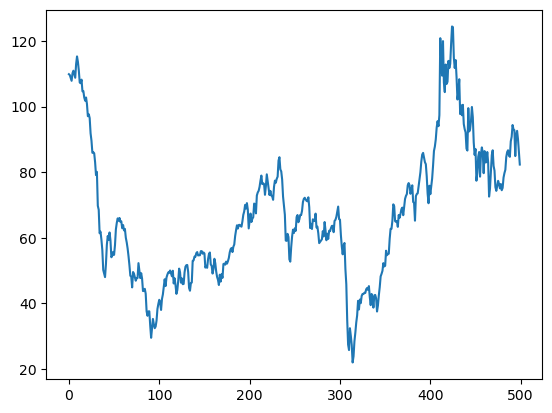

In [2]:


plt.plot(df['close'])